In [60]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [61]:
dir_data = './dataset'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

In [62]:
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

In [63]:
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

In [64]:
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

In [65]:
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)


In [66]:
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

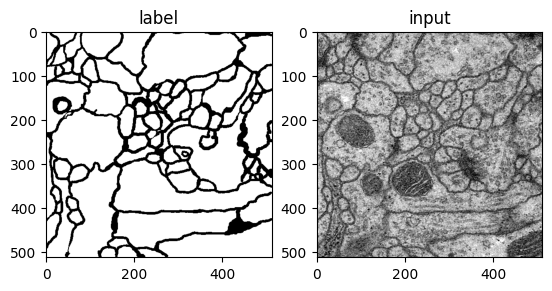

In [67]:
plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')
plt.subplot(122)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

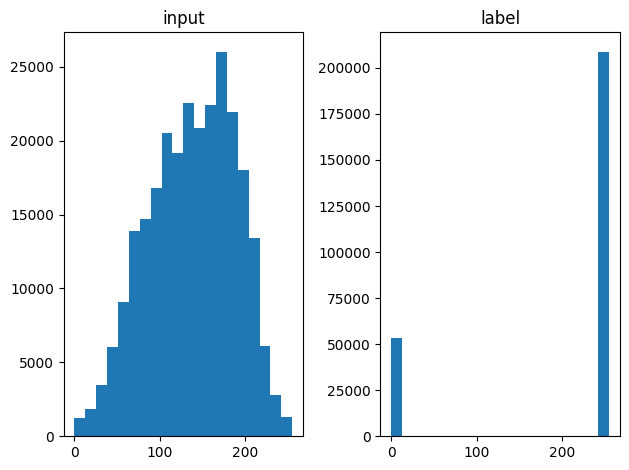

In [68]:
plt.subplot(122)
plt.hist(label_.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input_.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

In [69]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

In [78]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR2d(in_channels, out_channels, kernnal_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels,out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            
            return cbr
        
        self.enc1_1 = CBR2d(in_channels = 1, out_channels = 64)
        self.enc1_2 = CBR2d(in_channels = 64, out_channels = 64)
        
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.enc2_1 = CBR2d(in_channels = 64, out_channels = 128)
        self.enc2_2 = CBR2d(in_channels = 128, out_channels = 128)
        
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.enc3_1 = CBR2d(in_channels = 128, out_channels = 256)
        self.enc3_2 = CBR2d(in_channels = 256, out_channels = 256)
        
        self.pool3 = nn.MaxPool2d(kernel_size = 2)
        
        self.enc4_1 = CBR2d(in_channels = 256, out_channels = 512)
        self.enc4_2 = CBR2d(in_channels = 512, out_channels = 512)

        self.pool4 = nn.MaxPool2d(kernel_size = 2)

        self.enc5_1 = CBR2d(in_channels = 512, out_channels = 1024)
        
        
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    
     

In [79]:
 def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        
        return x

In [80]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()
        
        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        
        
        label = label/255.0
        input = input/255.0

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data
        

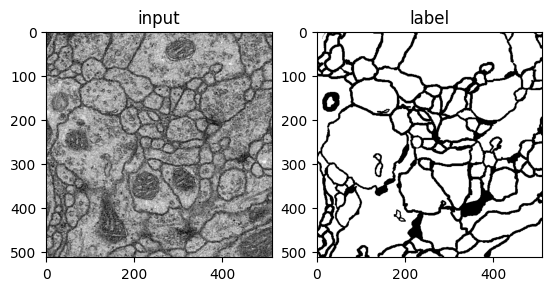

In [81]:
dataset_train = Dataset(data_dir=dir_save_train)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 시각화
plt.subplot(122)
plt.imshow(label.reshape(512,512), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(512,512), cmap='gray')
plt.title('input')

plt.show()

In [90]:
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'],data['input']
        
        label = label.transpose((2,0,1)).astype(np.float32)
        input = input.transpose((2,0,1)).astype(np.float32)
        
        data = {'label':torch.from_numpy(label), 'input':torch.from_numpy(input)}
        
        return data

In [91]:
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

In [92]:
class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)
            
        data = {'label':label, 'input':input}
        
        return data

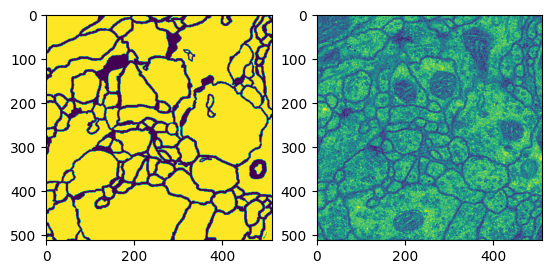

In [99]:
#구현

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기

input = data['input']
label = data['label']

plt.subplot(122)
plt.imshow(input.squeeze())

plt.subplot(121)
plt.imshow(label.squeeze())


plt.show()
